In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import random
import numpy as np
import os

In [3]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    # If you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function at the start of your script
set_seed(42)

In [4]:
# Hyperparameters
BATCH_SIZE = 16
INPUT_SIZE = 640
EPOCHS = 20
LEARNING_RATE = 0.0005
PATIENCE = 5
WARMUP_EPOCHS = 3
T_MAX = 10

In [5]:
# Data Transforms
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Datasets and DataLoaders
train_dataset = datasets.ImageFolder('/kaggle/input/datasaur-train-valid-10/data_10/train', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/datasaur-train-valid-10/data_10/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
os.mkdir('bests')

In [8]:
def yolo(model_name):
    # Model
    model = torch.hub.load('pytorch/vision:v0.13.0', model_name, weights='IMAGENET1K_V1')
    model = model.to(device)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.0005)

    # Learning Rate Scheduler with Warmup
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

    # Training Function
    def train(epoch):
        model.train()
        total_loss = 0.0
        for data, target in tqdm(train_loader, desc=f"Epoch {epoch}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}: Training Loss: {total_loss/len(train_loader)}")

    # Validation Function
    def validate():
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        for data, target in tqdm(val_loader, desc="Validating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

        f1 = f1_score(all_targets, all_preds, average='macro')
        acc = accuracy_score(all_targets, all_preds)
        print(f"Validation Loss: {val_loss/len(val_loader)} | F1 Score: {f1} | Accuracy: {acc}")
        return f1

    # Main Training Loop with Early Stopping
    best_f1 = 0.0
    counter = 0
    for epoch in range(1, EPOCHS+1):
        if epoch <= WARMUP_EPOCHS:
            warmup_factor = epoch / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = LEARNING_RATE * warmup_factor
        train(epoch)
        torch.cuda.empty_cache()
        with torch.no_grad():
          current_f1 = validate()
        scheduler.step()

        # Save best model
        if current_f1 > best_f1:
            best_f1 = current_f1
            torch.save(model.state_dict(), f'bests/{model_name}_best_model_at_epoch_{epoch}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= PATIENCE:
                print("Early stopping triggered!")
                break

    print(f"Training Completed for {model_name}!")



In [12]:
# models = ['efficientnet_b0']
models = ['resnet18']
for model_name in models:
    torch.cuda.empty_cache()
    yolo(model_name)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Epoch 1:   8%|▊         | 28/371 [00:15<03:05,  1.85it/s]


KeyboardInterrupt: 

In [10]:
os.mkdir('submissions')

In [7]:
import os
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

def submit(checkpoint_path):
    print('Doing', checkpoint_path.split('/')[-1].split('_best')[0])
    model = torch.hub.load('pytorch/vision:v0.13.0', checkpoint_path.split('/')[-1].split('_best')[0], weights='IMAGENET1K_V1')
    model = model.to(device)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
#     num_ftrs = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    
    
    # Load the trained model
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # Inference
    file_indices = []
    classes = []

    test_folder = '/kaggle/input/datasaur-test/test'
    test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpeg')]

    for image_name in tqdm(test_images, desc="Inference"):
        image_path = os.path.join(test_folder, image_name)

        # Load image and preprocess
        image = to_pil_image(read_image(image_path))
        image = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(image)
            pred = output.argmax(dim=1).item()

        # Store results
        file_index = image_name.split('.jpeg')[0]
        file_indices.append(file_index)
        classes.append(pred)

    # Create DataFrame and save to CSV
    submission_df = pd.DataFrame({
        'file_index': file_indices,
        'class': classes
    })

    submission_df.to_csv(f"submissions/{checkpoint_path.split('/')[-1]}_submission.csv", index=False)
    print("Saved predictions to submission.csv")


In [8]:
from glob import glob

In [18]:
models = glob('/kaggle/input/models-datasaur/*.pth')

In [20]:
models = [
    '/kaggle/input/models-datasaur/efficientnet_b2_best_model_at_epoch_12.pth',
    '/kaggle/input/models-datasaur/efficientnet_b0_best_model_at_epoch_14.pth',
]

In [17]:
for model_name in models:
    torch.cuda.empty_cache()
    submit(model_name)

Doing efficientnet_b0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Inference: 100%|██████████| 777/777 [00:24<00:00, 31.26it/s]


Saved predictions to submission.csv


In [10]:
import os
import torch
import numpy as np
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model function
def load_model(model_path):
    if 'resnet' in model_path:
       model =  torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', weights='IMAGENET1K_V1')
    else:
        model = torch.hub.load('pytorch/vision:v0.13.0', model_path.split('/')[-1].split('_best')[0], weights='IMAGENET1K_V1')
    if 'resnet' in model_path.split('/')[-1].split('_best')[0]:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    else:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def get_probabilities(model, image):
    with torch.no_grad():
        output = torch.nn.functional.softmax(model(image), dim=1)
    return output.cpu().numpy()

# List of models
models_paths = [
    '/kaggle/input/models-datasaur/efficientnet_b2_best_model_at_epoch_12.pth',
    '/kaggle/input/models-datasaur/efficientnet_b0_best_model_at_epoch_14.pth',
    '/kaggle/input/resnet-18/best_model_resnet18.pth'
]

models = [load_model(path) for path in models_paths]

# Implement voting classifier using probabilities
final_predictions = []

test_folder = '/kaggle/input/datasaur-test/test'
test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpeg')]

for image_name in tqdm(test_images, desc="Inference"):
    image_path = os.path.join(test_folder, image_name)
    
    # Load image, convert to PIL Image and preprocess
    image = to_pil_image(read_image(image_path))
    image = transform(image).unsqueeze(0).to(device)
    
    # Get probabilities using all models
    probs = [get_probabilities(model, image) for model in models]
    
    # Average the probabilities
    avg_probs = np.mean(probs, axis=0)
    
    # Get class with highest average probability
    final_class = np.argmax(avg_probs)
    
    final_predictions.append(final_class)

# Now, you can save 'final_predictions' to your CSV as done previously.


Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 91.2MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 99.0MB/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 261MB/s]
Inference: 100%|██████████| 777/777 [00:42<00:00, 18.50it/s]


In [11]:
import pandas as pd

# Extract image names without the '.jpeg' extension
file_indices = [image_name.split('.jpeg')[0] for image_name in test_images]

# Create a DataFrame
submission_df = pd.DataFrame({
    'file_index': file_indices,
    'class': final_predictions
})

# Save to CSV
submission_df.to_csv('submission_vote.csv', index=False)
print("Saved predictions to submission.csv")


Saved predictions to submission.csv


In [12]:
import os
import shutil

# Create the labeled_test directory and class directories inside it
output_dir = 'labeled_test'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class_dirs = [os.path.join(output_dir, str(i)) for i in range(2)]  # Assuming 2 classes: 0 and 1
for class_dir in class_dirs:
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Copy images to their respective predicted class folders
for image_name, prediction in zip(test_images, final_predictions):
    src_path = os.path.join(test_folder, image_name)
    dest_path = os.path.join(output_dir, str(prediction), image_name)
    shutil.copy(src_path, dest_path)

print("Images have been copied to the labeled_test folder based on predictions.")


Images have been copied to the labeled_test folder based on predictions.


In [13]:
# Zip the labeled_test folder
shutil.make_archive('labeled_test', 'zip', 'labeled_test')
print("labeled_test folder has been zipped as labeled_test.zip")

labeled_test folder has been zipped as labeled_test.zip


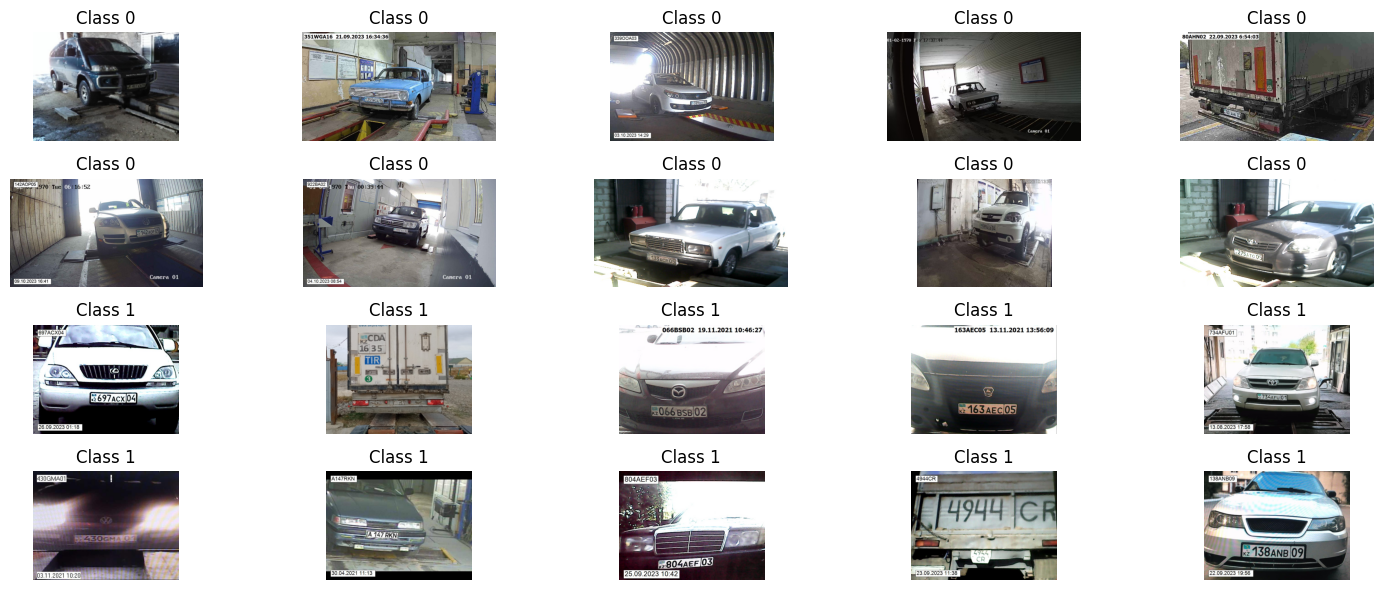

In [16]:
import math
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images_from_class(class_dir, num_images=5):
    """
    Load and return `num_images` random images from a directory.
    """
    all_images = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]
    selected_images = random.sample(all_images, num_images)
    return [Image.open(os.path.join(class_dir, img_path)) for img_path in selected_images]

# Define number of random images to visualize from each class
NUM_IMAGES = 10
IMAGES_PER_ROW = 5

# Load random images
class_0_images = plot_random_images_from_class(class_dirs[0], NUM_IMAGES)
class_1_images = plot_random_images_from_class(class_dirs[1], NUM_IMAGES)

rows_per_class = math.ceil(NUM_IMAGES / IMAGES_PER_ROW)

# Plot
fig, axs = plt.subplots(rows_per_class * 2, IMAGES_PER_ROW, figsize=(15, 6))

# Function to plot images for a class
def plot_images_for_class(images, start_row):
    for i, img in enumerate(images):
        row = start_row + i // IMAGES_PER_ROW
        col = i % IMAGES_PER_ROW
        if rows_per_class == 1:
            ax = axs[start_row + col]  # Single row
        else:
            ax = axs[row, col]  # Multiple rows
        ax.imshow(img)
        ax.set_title(f"Class {start_row // rows_per_class}")
        ax.axis('off')

plot_images_for_class(class_0_images, 0)
plot_images_for_class(class_1_images, rows_per_class)

plt.tight_layout()
plt.show()
